In [1]:
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
class AntColonyOptimizer():
    def __init__(self, distance_matrix: np.ndarray, n_ants: int, n_epochs: int, alpha: float, beta: float, rho: float):
        assert n_ants > 0
        assert n_epochs > 0
        assert distance_matrix.shape[0] == distance_matrix.shape[1]
        assert distance_matrix.shape[0] > 1
        self.n_ants = n_ants
        self.n_epochs = n_epochs
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.distance_matrix = distance_matrix
        self.symmetric = np.all(distance_matrix == distance_matrix.T)
        self.n_points = distance_matrix.shape[0]
        self.q = np.mean(distance_matrix)*self.n_points - 2*np.std(distance_matrix)*np.sqrt(self.n_points)
        self.pheromone = np.ones(shape=(self.n_points, self.n_points))
        self.best_path = None
        self.best_length = float('inf')
    

    def __move_probs(self, visited: np.ndarray, curr_point: int) -> np.ndarray:
        assert 0 <= curr_point < self.n_points
        assert visited.dtype == bool
        probs = np.zeros(self.n_points)
        for j in range(self.n_points):
            if not visited[j]:
                probs[j] = self.pheromone[curr_point, j]**self.alpha * (1/self.distance_matrix[curr_point, j])**self.beta
        probs /= np.sum(probs)
        return probs
    

    def __path_length(self, path: np.ndarray) -> float:
        assert path.shape == (self.n_points,)
        length = 0
        for i in range(self.n_points-1):
            length += self.distance_matrix[path[i], path[i+1]]
        length += self.distance_matrix[path[-1], path[0]]
        return length


    def __ant_walk(self) -> tuple:
        visited = np.zeros(self.n_points, dtype=bool)
        path = np.zeros(self.n_points, dtype=int)
        path[0] = np.random.randint(0, self.n_points)
        visited[path[0]] = True
        for i in range(1, self.n_points):
            probs = self.__move_probs(visited, path[i-1])
            chosen_point = np.random.choice(np.arange(self.n_points), p=probs)
            path[i] = chosen_point
            visited[chosen_point] = True
        return path, self.__path_length(path)
    

    def __update_pheromone(self):
        assert self.best_path is not None

        self.pheromone *= 1 - self.rho # Evaporate pheromone
        
        for i in range(self.n_points-1):
            self.pheromone[self.best_path[i], self.best_path[i+1]] += self.q/self.best_length
            if self.symmetric:
                self.pheromone[self.best_path[i+1], self.best_path[i]] = self.pheromone[self.best_path[i], self.best_path[i+1]]
        
        self.pheromone[self.best_path[-1], self.best_path[0]] += self.q/self.best_length
        if self.symmetric:
            self.pheromone[self.best_path[0], self.best_path[-1]] = self.pheromone[self.best_path[-1], self.best_path[0]]

    
    def __update_pheromone_per_ant(self, path, length):
        self.pheromone *= 1 - self.rho # Evaporate pheromone
        
        for i in range(self.n_points-1):
            self.pheromone[path[i], path[i+1]] += self.q/length
            if self.symmetric:
                self.pheromone[path[i+1], path[i]] = self.pheromone[path[i], path[i+1]]
        
        self.pheromone[path[-1], path[0]] += self.q/length
        if self.symmetric:
            self.pheromone[path[0], path[-1]] = self.pheromone[path[-1], path[0]]


    def __optim_step(self):
        for k in range(self.n_ants):
            path, length = self.__ant_walk()
            #self.__update_pheromone_per_ant(path, length)
            if self.best_length > length:
                self.best_length = length
                self.best_path = path
        self.__update_pheromone()
    

    def optimize(self, path_history: list = None, length_history: list = None, pheromone_history: list = None):
        for i in range(self.n_epochs):
            self.__optim_step()
            
            if path_history is not None:
                path_history.append(self.best_path.copy())

            if length_history is not None:
                length_history.append(self.best_length.copy())

            if pheromone_history is not None:
                pheromone_history.append(self.pheromone.copy())

        return self.best_path, self.best_length

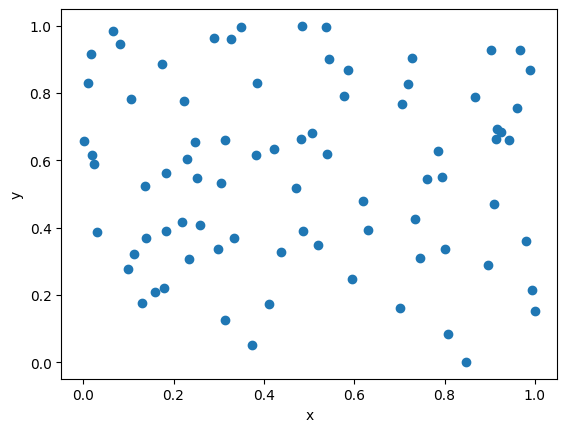

In [3]:
N = 80
points = np.random.random((N,2))

plt.scatter(points[:,0], points[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
distances = np.array([[np.linalg.norm(points[i]-points[j]) for j in range(N)] for i in range(N)])

In [5]:
aco = AntColonyOptimizer(distances, n_ants=50, n_epochs=100, alpha=1, beta=2, rho=0.1)
path_history = []
length_history = []
pheromone_history = []
path, length = aco.optimize(path_history, length_history, pheromone_history)
print(path)
print(length)

[ 5 62 49 50 34 53 71 66 11 44 75 43 61 38 45 25 76 12 46 40 10 65 13 14
 52 36 26 24  6 74 41 67 70 79 63 29 37  8 22 15  2 31 18 55 27 48  9 77
 64 42 30 68 69 28 51  7 72  0 39 19 47 54 78 56 20 33 57  4 21  1 59 60
 16 58  3 23 35 73 32 17]
8.045087906669417


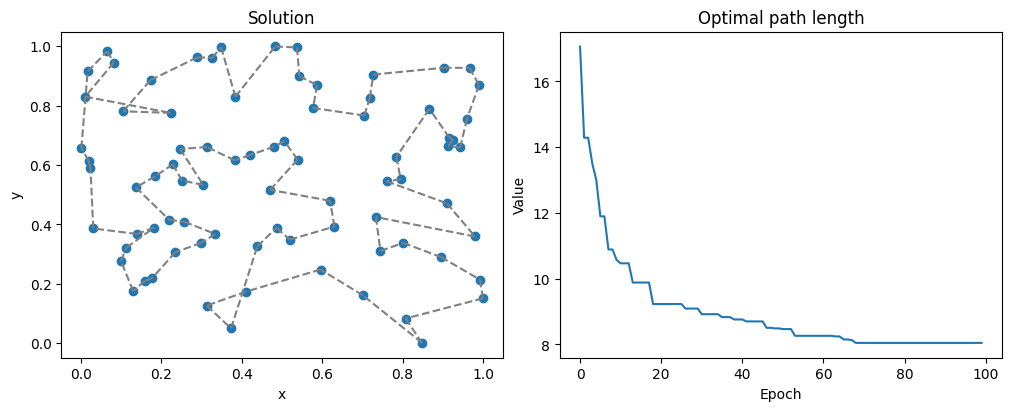

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4), constrained_layout=True)

# --- Plot solution ---
for i in range(N-1):
    p1 = points[path[i], :]
    p2 = points[path[i+1], :]
    ax[0].plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linestyle='dashed')

p1 = points[path[-1], :]
p2 = points[path[0], :]
ax[0].plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linestyle='dashed')
ax[0].scatter(points[:,0], points[:,1])
ax[0].set_title('Solution')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

# --- Plot length history ---
ax[1].plot(length_history)
ax[1].set_title('Optimal path length')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Value')

plt.show()

In [7]:
pheromone_history = np.array(pheromone_history)
pheromone_history /= np.max(pheromone_history)

In [8]:
entropy_history = [entropy(pheromone_history[i].flatten()) for i in range(len(pheromone_history))]
entropy_history = np.array(entropy_history)

In [9]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,8), constrained_layout=True)
fig.suptitle('Solving the TSP with Ant Colony Optimization (by Filipe Chagas)')

# --- Plot initial state ---
path_axlines = []
for i in range(N-1):
    p1 = points[path[i], :]
    p2 = points[path[i+1], :]
    axline, = ax[0,0].plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linestyle='dashed')
    path_axlines.append(axline)

p1 = points[path[-1], :]
p2 = points[path[0], :]
axline, = ax[0,0].plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linestyle='dashed')
path_axlines.append(axline)

ax[0,0].scatter(points[:,0], points[:,1])
ax[0,0].set_title('Solution')
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('y')

# --- Plot initial pheromone graph ---
pheromone_axlines = dict()
min_pheromone_color = np.array([1.0, 0.0, 0.0, 0.0])
max_pheromone_color = np.array([1.0, 0.0, 0.0, 1.0])
for i in range(N):
    for j in range(i+1, N):
        axline, = ax[0,1].plot(points[[i,j],0], points[[i,j],1], color=min_pheromone_color)
        pheromone_axlines[(i,j)] = axline
#ax[0,1].scatter(points[:,0], points[:,1])
ax[0,1].set_title('Pheromone trails')
ax[0,1].set_xlabel('x')
ax[0,1].set_ylabel('y')

# --- Plot length ---
length_axline, = ax[1,0].plot([0], [0])
ax[1,0].set_title('Path length')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_xlim(0, len(length_history))
ax[1,0].set_ylim(min(length_history), max(length_history))
ax[1,0].grid()

# --- Entropy ---
entropy_axline, = ax[1,1].plot([0], [0])
ax[1,1].set_title('Pheromone distribution entropy')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_xlim(0, len(entropy_history))
ax[1,1].set_ylim(min(entropy_history), max(entropy_history))
ax[1,1].grid()

def animate(k):
    # --- Solution ---
    path = path_history[k]
    pheromone = pheromone_history[k]
    for i in range(N-1):
        p1 = points[path[i], :]
        p2 = points[path[i+1], :]
        path_axlines[i].set_data([p1[0], p2[0]], [p1[1], p2[1]])
    
    p1 = points[path[-1], :]
    p2 = points[path[0], :]
    path_axlines[-1].set_data([p1[0], p2[0]], [p1[1], p2[1]])

    # --- Pheromone ---
    for i in range(N):
        for j in range(i+1, N):
            phi = pheromone[i,j]
            pheromone_axlines[(i,j)].set_color((1-phi)*min_pheromone_color + phi*max_pheromone_color)
    
    # --- Length axline ---
    length_axline.set_data(np.arange(k)+1, length_history[:k])

    # --- Entropy axline ---
    entropy_axline.set_data(np.arange(k)+1, entropy_history[:k])

ani = FuncAnimation(fig, animate, frames=len(path_history), interval=100)
ani.save('tsp-aco-filipe.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(4,4), constrained_layout=True)

# --- Plot initial state ---
path_axlines = []
for i in range(N-1):
    p1 = points[path[i], :]
    p2 = points[path[i+1], :]
    axline, = ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linestyle='dashed', zorder=1)
    path_axlines.append(axline)

p1 = points[path[-1], :]
p2 = points[path[0], :]
axline, = ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linestyle='dashed', zorder=1)
path_axlines.append(axline)

# --- Plot initial pheromone graph ---
pheromone_axlines = dict()
min_pheromone_color = np.array([1.0, 0.0, 0.0, 0.0])
max_pheromone_color = np.array([1.0, 0.0, 0.0, 1.0])
for i in range(N):
    for j in range(i+1, N):
        axline, = ax.plot(points[[i,j],0], points[[i,j],1], color=min_pheromone_color, zorder=0)
        pheromone_axlines[(i,j)] = axline

ax.scatter(points[:,0], points[:,1], zorder=2)
ax.set_xlabel('x')
ax.set_ylabel('y')

def animate(k):
    # --- Solution ---
    path = path_history[k]
    pheromone = pheromone_history[k]
    for i in range(N-1):
        p1 = points[path[i], :]
        p2 = points[path[i+1], :]
        path_axlines[i].set_data([p1[0], p2[0]], [p1[1], p2[1]])
    
    p1 = points[path[-1], :]
    p2 = points[path[0], :]
    path_axlines[-1].set_data([p1[0], p2[0]], [p1[1], p2[1]])

    # --- Pheromone ---
    for i in range(N):
        for j in range(i+1, N):
            phi = pheromone[i,j]
            pheromone_axlines[(i,j)].set_color((1-phi)*min_pheromone_color + phi*max_pheromone_color)
    

ani = FuncAnimation(fig, animate, frames=len(path_history), interval=100)
ani.save('tsp-aco-thumbnail.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.
